In [1]:
import gym
import numpy as np
import time

In [2]:
def discretize(min, max, num):
    return np.linspace(min, max, num + 1)[1:-1]

In [3]:
def digitize_state(observation, fineness):
    cart_x, cart_v, pole_th, pole_v = observation
    digitized_state = [
        np.digitize(cart_x,  bins=discretize(-2.4, 2.4, fineness)),
        np.digitize(cart_v,  bins=discretize(-3.0, 3.0, fineness)),
        np.digitize(pole_th, bins=discretize(-0.5, 0.5, fineness)),
        np.digitize(pole_v,  bins=discretize(-2.0, 2.0, fineness))
    ]
    return sum([x * (fineness**i) for i, x in enumerate(digitized_state)])

In [4]:
def update_qtable(q_table, current_status, action, next_status, current_reward):
    alpha = 0.5
    gamma = 0.99
    next_reward = np.max(q_table[next_status])
    q_table[current_status, action] = (1 - alpha) * q_table[current_status, action] + \
                                        alpha * (current_reward + gamma * next_reward)
    return q_table

In [5]:
def calc_action(status, q_table, episode):
    epsilon = 1.0 / (episode + 1) * 0.5
    if epsilon < np.random.uniform(0, 1):
        return np.argmax(q_table[status])
    else:
        return np.random.choice([0, 1])

In [18]:
def calc_reward(observation, done, current_step, max_steps):
    if done:
        return max_steps - np.abs(observation).sum()*20 if current_step + 1 >= max_steps * 0.95 else 0.5 * current_step - max_steps
    else:
        return 5.0 - np.abs(observation).sum()
#         return 1

In [19]:
episode_rewards = []
q_table = np.array([])

def main():
    FINENESS = 6
    EPISODES  = 2000
    MAX_STEPS = 200
      
    env = gym.make('CartPole-v1')
    table_size = (FINENESS**env.observation_space.shape[0], env.action_space.n)
    q_table = np.random.uniform(low=-1, high=1, size=table_size)
    
    for episode in range(EPISODES):
        observation = env.reset()
        episode_reward = 0
        
        for step in range(MAX_STEPS):
            # do action
            current_status = digitize_state(observation, FINENESS)
            action = calc_action(current_status, q_table, episode)
            observation, reward, done, info = env.step(action)
            
            # calc reward
            reward = calc_reward(observation, done, step, MAX_STEPS)
            episode_reward += reward

            # update q_table
            next_status = digitize_state(observation, FINENESS)
            q_table = update_qtable(q_table, current_status, action, next_status, reward)
            
            # render
            if (episode + 1) % 100 == 0:
                env.render()
                time.sleep(0.01)
            
            if done:
                break
        episode_rewards.append(episode_reward)
        if episode % 500 == 0:
            print("Progress: {} / {}".format(episode, EPISODES))
    
    print(q_table)  
    env.close()

main()

Progress: 0 / 2000
Progress: 500 / 2000
Progress: 1000 / 2000
Progress: 1500 / 2000
[[-8.84920405e-01 -8.19563044e-01]
 [-9.92017457e-01  6.25902556e-01]
 [ 1.72773492e-01  1.16006881e-01]
 ...
 [-8.52714989e-01  3.23279201e-02]
 [-5.64714472e-01  1.50424207e-04]
 [-3.45098076e-01  4.15059174e-01]]


In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

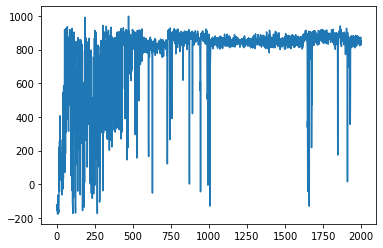

In [21]:
x = np.arange(len(episode_rewards))
y = np.array(episode_rewards)

plt.plot(x, y)
plt.show()